Introduction to AI & Data Science assignment <br>
Machine learning forecasting using regression (SARIMAX) <br>
Task: To predict the Indonesian stock market at the first part of 2023: bullish or bear? <br>

In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)
simplefilter(action='ignore', category=UserWarning)

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import itertools

In [4]:
# taking data from yahoo finance
import yfinance as yf
# training data
symbol = '^JKSE' # Indonesia Stock Index
dl_start="2010-01-01"
dl_end = "2022-12-30" # end. we will forecast 2023 first six months
df = yf.download(symbol,start=dl_start, end=dl_end)

[*********************100%%**********************]  1 of 1 completed


In [5]:
# I will use Adj Close instead of Close. Adj Close incorporated dividen & other corporate actions
df['Close'] = df['Adj Close']
drop_cols = ['Volume', 'Open', 'Low', 'High', 'Adj Close']
df = df.drop(drop_cols,axis=1)

In [6]:
df.isnull().values.any()

False

In [7]:

df.isna().values.any()

False

In [8]:
df.index.min(), df.index.max()

(Timestamp('2010-01-04 00:00:00'), Timestamp('2022-12-29 00:00:00'))

In [9]:
df.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23', '2022-12-26', '2022-12-27',
               '2022-12-28', '2022-12-29'],
              dtype='datetime64[ns]', name='Date', length=3172, freq=None)

In [10]:
# We will be using the averages daily closing price for each month to forecast
# The start of each month as the timestamp
y = df['Close'].resample('MS').mean()


In [11]:
y.shape

(156,)

There are 72 months of data

In [12]:
y.isna().values.any()

False

In [13]:
# Have a quick peek the closing price since 2017
y['2017':]

Date
2017-01-01    5294.857422
2017-02-01    5370.014880
2017-03-01    5478.665261
2017-04-01    5649.746180
2017-05-01    5692.100830
                 ...     
2022-08-01    7115.565629
2022-09-01    7188.818204
2022-10-01    6986.436709
2022-11-01    7046.161266
2022-12-01    6839.629604
Freq: MS, Name: Close, Length: 72, dtype: float64

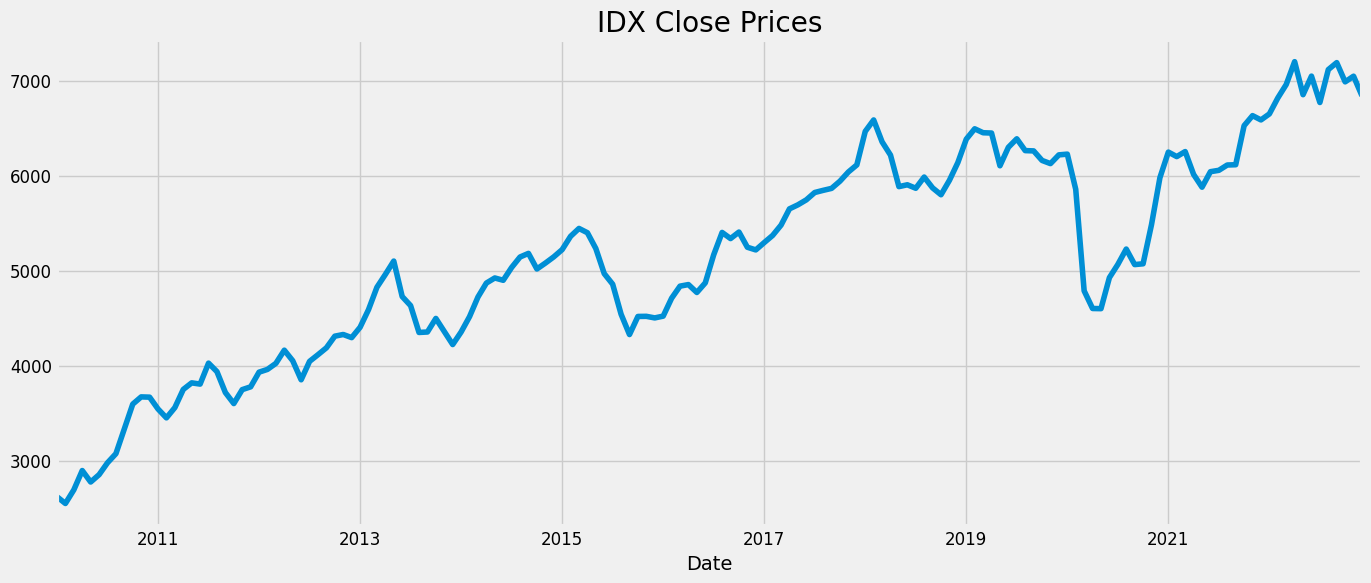

In [14]:
# Visualizing the close price
y.plot(figsize=(15, 6))
plt.title('IDX Close Prices')
plt.show()

Observation:
1) The stock price from 2018 to 2020 was sideways in the range of 5500 - 6500 after trending up in 2017
2) There were huge dips in the stock prices in March 2020(due to the Pandemic).
3) The stock prices increased from 2020 (after the new normal) to early 2023
4) The stock price was sideways from mid 2022 to end 2022
So, what will happen in 2023 semester 1?

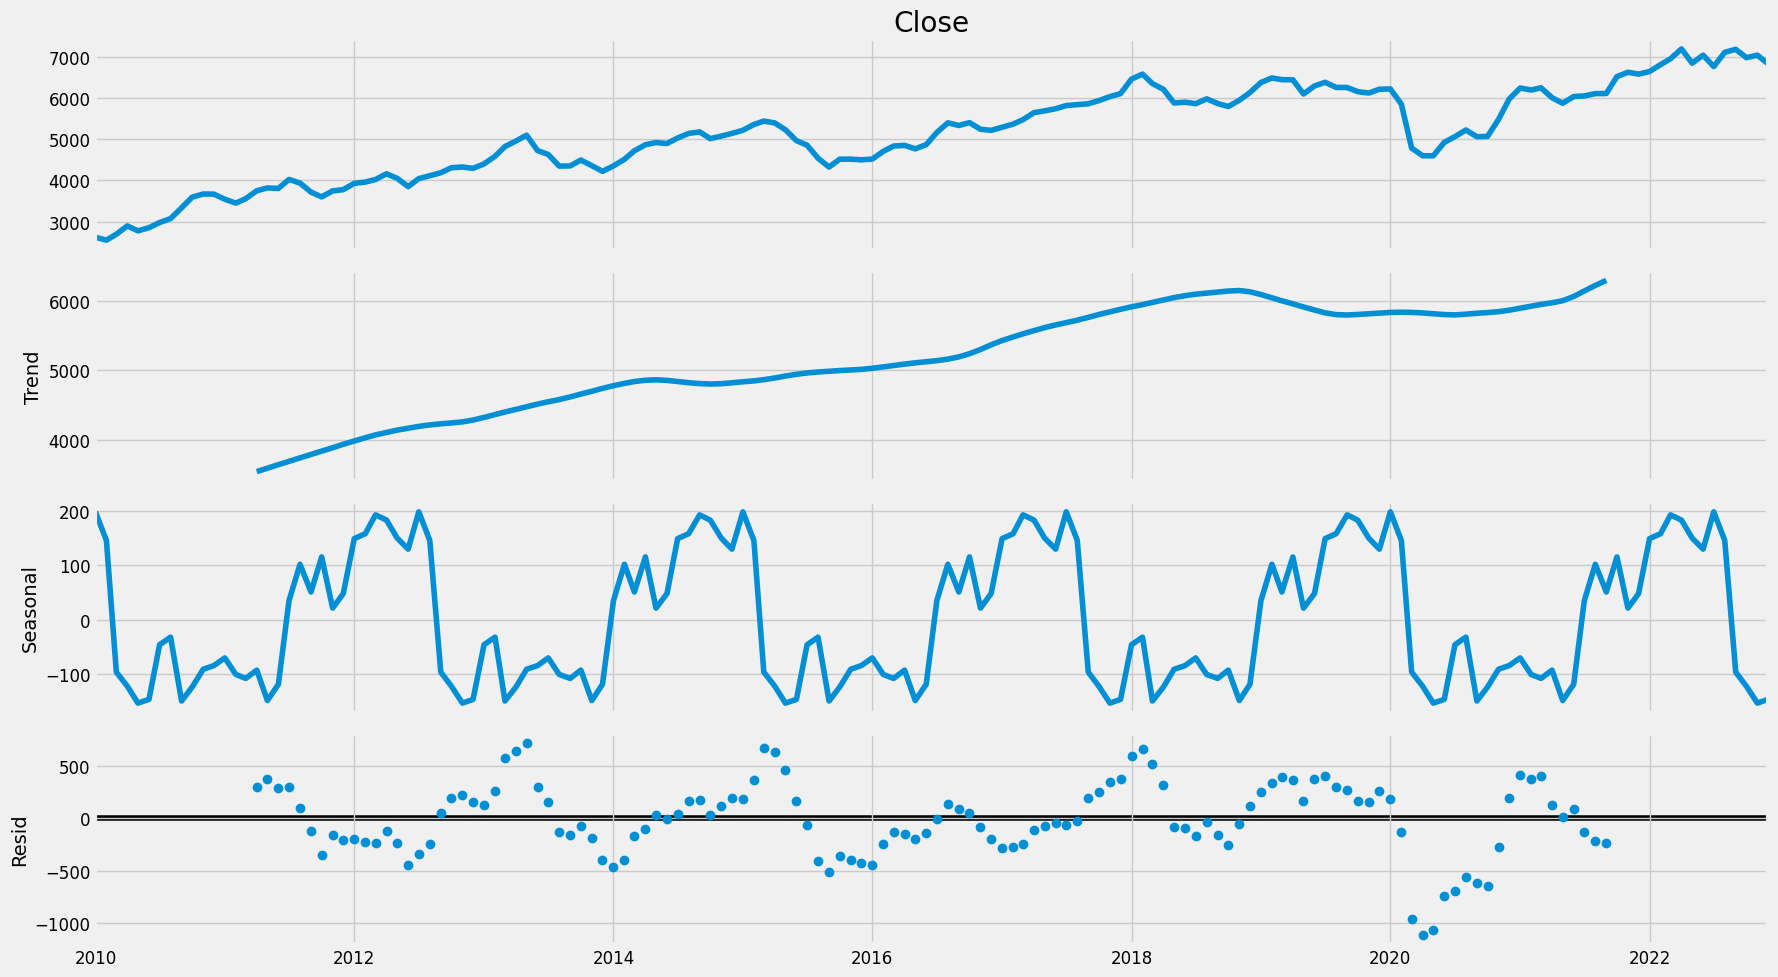

In [27]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(y, model='additive',period=30)
fig = decomposition.plot()
#plt.title('Decompose - IDX Close Prices')
plt.show()

Observation:
1) Trend: downward trend followed by the mostly linear upward trend
2) Seasonality: Interestingly, it seems there is seasonality every 2.5-3 years
 a) end of 2017 to 2020 (3+12+12 = 27 months)
 b) early 2020 to mid 2022 (9+12+6 = 27 months)
3) Residuals: the index price is susceptible to random shocks and noise. Of course, this is the stock market.

In [16]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [17]:
# This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find 
# the optimal set of parameters that yields the best performance for our model.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3098.7045771970816
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2702.35312622759
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2291.5768192737933
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2099.2113888161352
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2289.442424692157
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2268.292196662921
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2114.566565291955
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2099.7150680720542
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2969.610530049912
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2717.6889621053865
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2116.644425994436
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1938.000961615734
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2133.330513147118
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2100.4500959498837
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1966.5249859092685
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1933.061630782474
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2051.0250802397536
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1896.288228304849
ARI

The setting ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:633.959576518351 produce the lowest AIC.
Let's use this parameters

In [18]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2202      0.239      0.922      0.357      -0.248       0.688
ma.L1          0.1335      0.243      0.550      0.583      -0.343       0.610
ma.S.L12      -0.7219      0.060    -12.059      0.000      -0.839      -0.605
sigma2      3.424e+04   3181.314     10.763      0.000     2.8e+04    4.05e+04


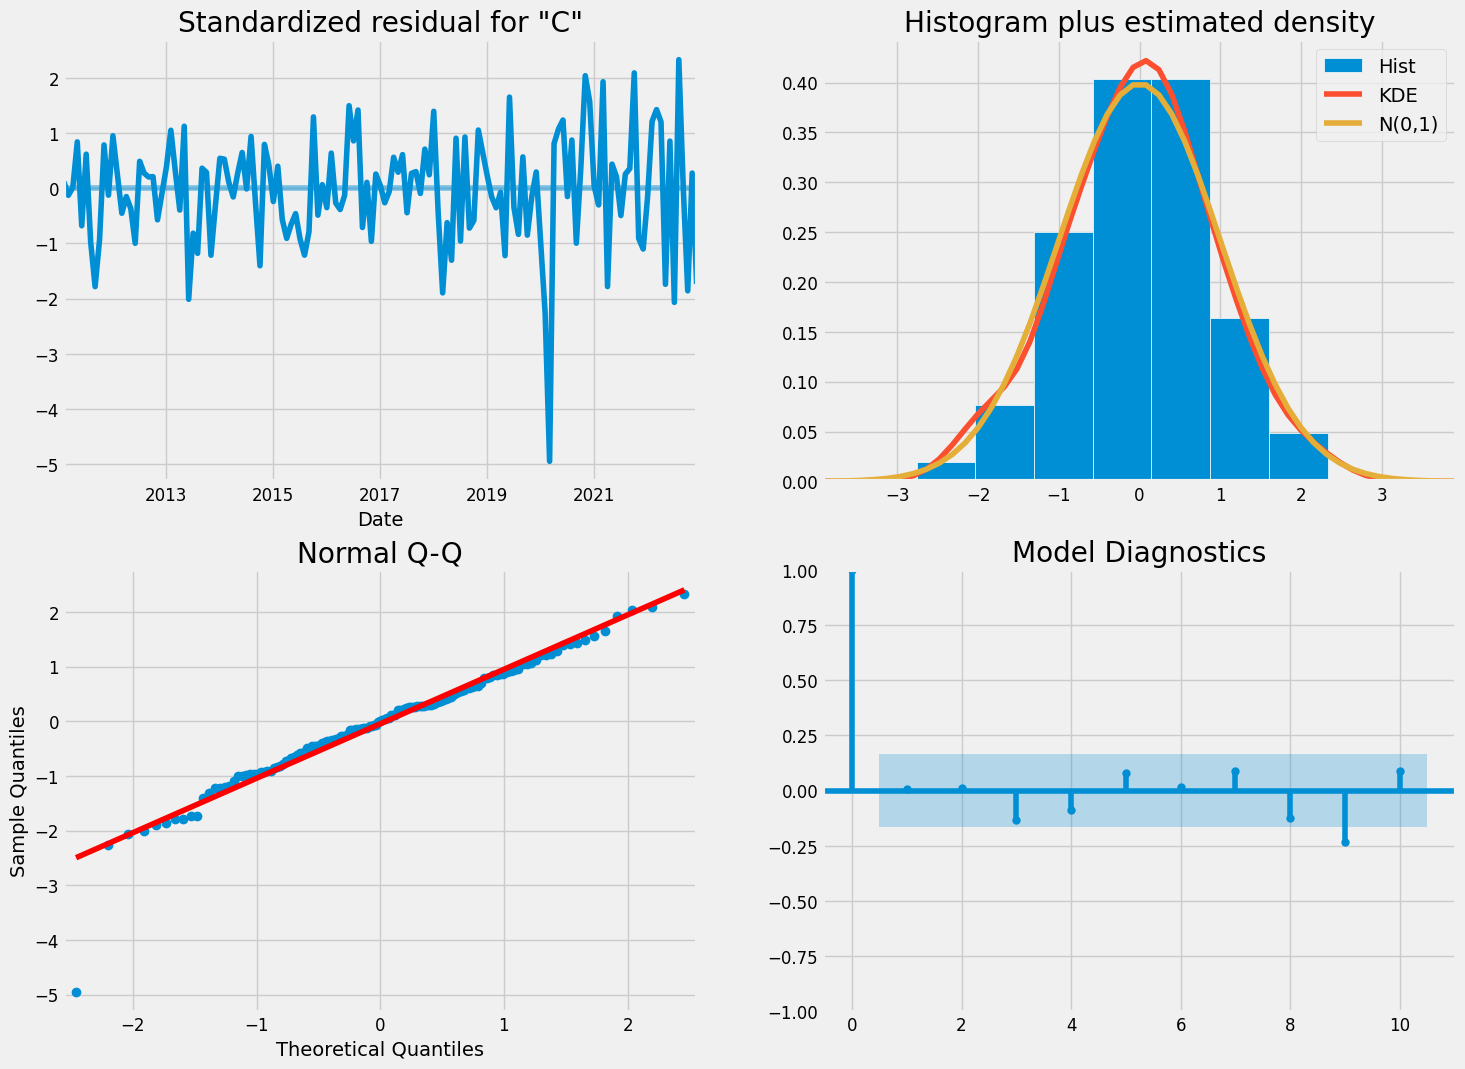

In [19]:
# We should always run model diagnostics to investigate any unusual behavior
results.plot_diagnostics(figsize=(16, 12))
plt.title('Model Diagnostics')
plt.show()

It is not perfect, however, our model diagnostics suggest that the model residuals are nearly normally distributed.
Points on the Normal Q-Q Plot indicate the univariate normality of the dataset. If the data is not normally distributed, the points will deviate from the reference line.

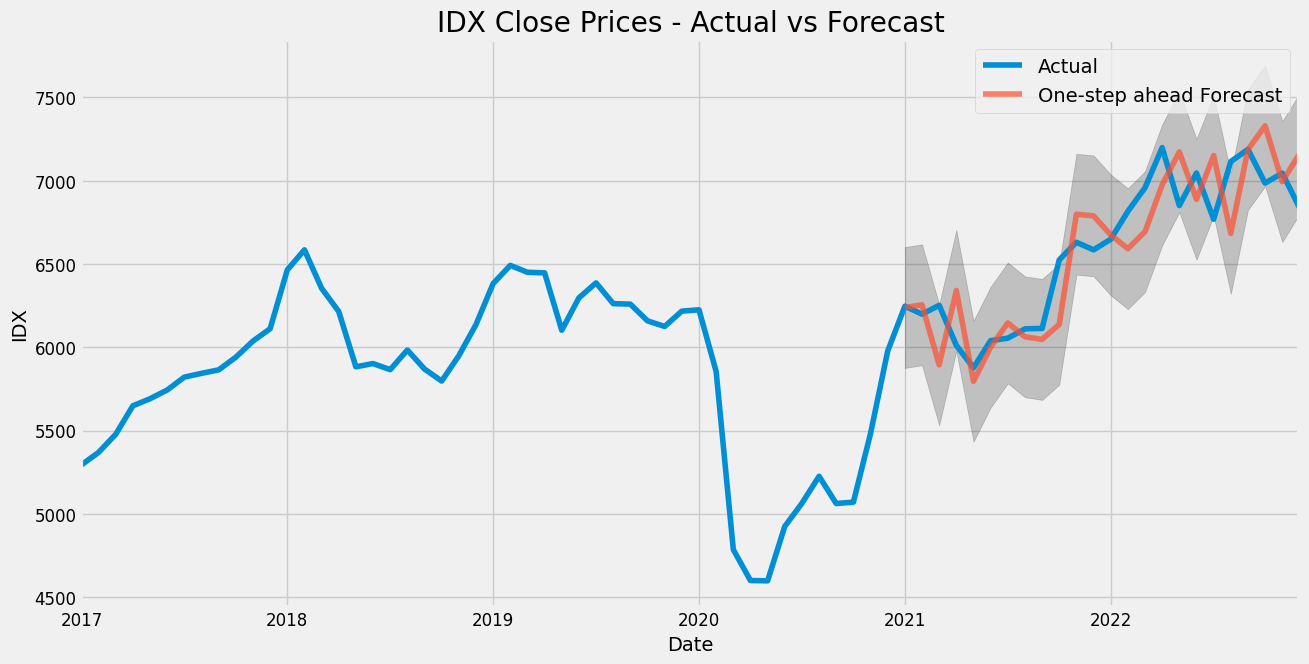

In [20]:
pred = results.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2017':].plot(label='Actual')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('IDX')
plt.title('IDX Close Prices - Actual vs Forecast')
plt.legend()
plt.show()

The line plot shows the observed values compared to the rolling forecast predictions. Overall, this forecast aligns with the actual values very well, showing an upward trend starting from the beginning of the year.

In [21]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 55697.3


In [22]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 236.0


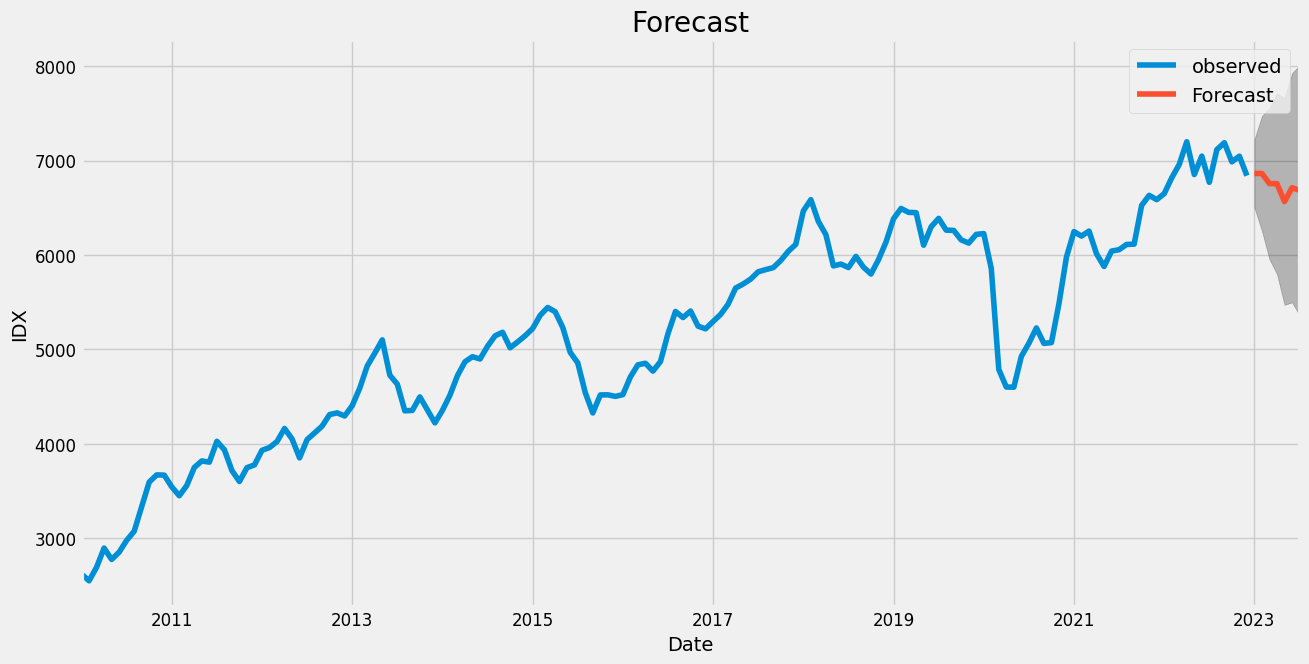

In [23]:
# Producing and visualizing forecasts
pred_uc = results.get_forecast(steps=7)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('IDX')
plt.title('Forecast')
plt.legend()
plt.show()

Based on this forecast, the earlier part of 2023 will be neither bullish nor bearish. It will be in the sideways trading range between 6500 to 7000.
Let's confirm with the actual.

In [24]:
# I download the actual until mid 2023
dl_start="2017-01-01"
dl_end = "2023-06-30" # 6 months
act = yf.download(symbol,start=dl_start, end=dl_end)

[*********************100%%**********************]  1 of 1 completed


In [25]:
# I will use Adj Close instead of Close. Adj Close incorporated dividen & other corporate actions
act['Close'] = act['Adj Close']
drop_cols = ['Volume', 'Open', 'Low', 'High', 'Adj Close']
act = act.drop(drop_cols,axis=1)
act = act['Close'].resample('MS').mean()

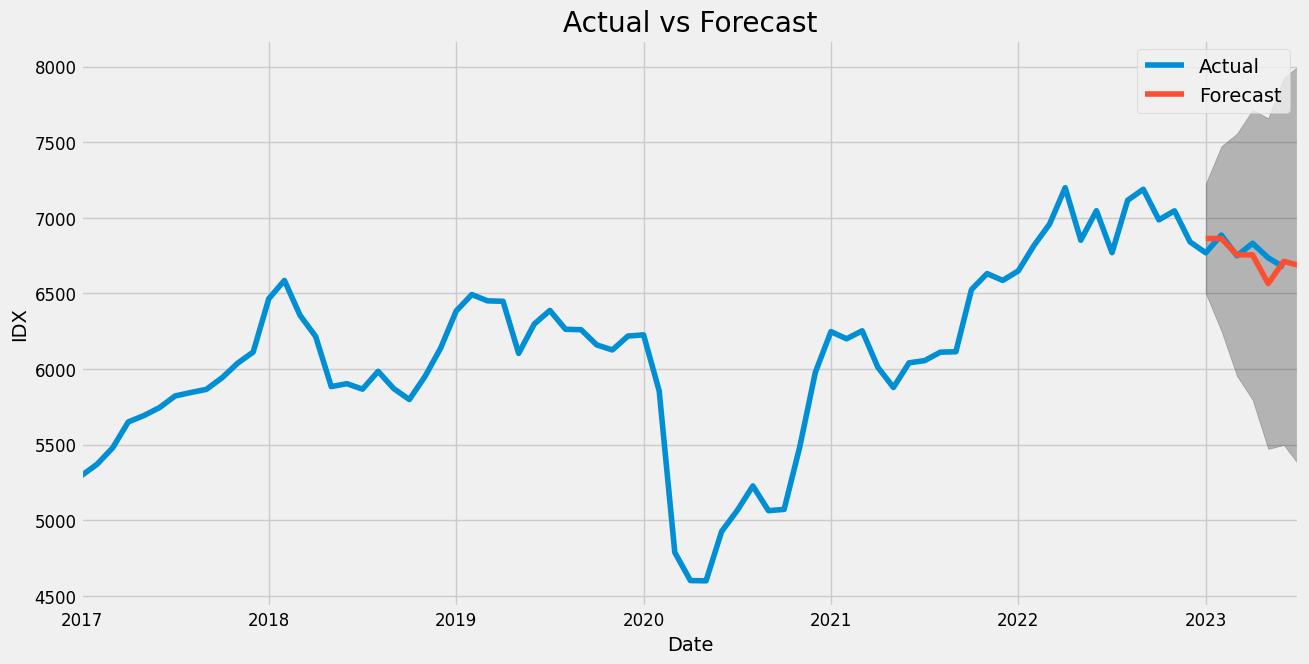

In [26]:
# Producing and visualizing forecasts
#pred_uc = results.get_forecast(steps=10)
#pred_ci = pred_uc.conf_int()
ax = act.plot(label='Actual', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('IDX')
plt.title('Actual vs Forecast')
plt.legend()
plt.show()

Eventhough they are not very close but it confirms that the first semester of 2023, the JKSE will trading in sideways/swing in the range 6500 to 7000.
In the future to improve the performance, I will add more predictors/technical indicators.


Reference:<br>
https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html <br>
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3 <br>